In [ ]:
# docker run -p 6333:6333 qdrant/qdrant
# pip install langgraph langchain langchain-community qdrant-client groq sqlparse asttokens javalang

In [46]:
from langgraph.graph import StateGraph, START, END
from langchain_core.runnables import RunnableLambda
from langchain_groq import ChatGroq
from langchain_community.vectorstores import Qdrant
from langchain.embeddings import HuggingFaceEmbeddings
from qdrant_client import QdrantClient
from langchain.schema import Document
from typing import TypedDict, List, Optional, Dict, Any, Literal
from qdrant_client.http.models import Distance, VectorParams


import sqlparse, javalang, asttokens, ast, os, uuid, json
from dotenv import load_dotenv
load_dotenv()


True

In [20]:
class CodeState(TypedDict):
    file_path: Optional[str]
    code: Optional[str]
    metadata_file: Optional[str]
    language: Optional[str]
    chunks: Optional[List[str]]
    summaries: Optional[List[str]]
    high_level_doc: Optional[str]
    detailed_doc: Optional[str]
    table_names: Optional[List[str]]
    question: Optional[str]
    answer: Optional[str]
    chunk_trace: Optional[List[Dict[str, Any]]]


In [5]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0.3)

# embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2") #size=384
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
qdrant_client = QdrantClient(host="localhost", port=6333)

# Create collection
qdrant_client.recreate_collection(
    collection_name="code_chunks",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE)
)


vector_store = Qdrant(
    client=qdrant_client,
    collection_name="code_chunks",
    embeddings=embedding_model
)

C:\Users\Uttam Kumar\AppData\Local\Temp\ipykernel_18448\1450245719.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
C:\Users\Uttam Kumar\AppData\Local\Temp\ipykernel_18448\1450245719.py:10: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(
C:\Users\Uttam Kumar\AppData\Local\Temp\ipykernel_18448\1450245719.py:16: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.

In [ ]:
# Function to read code from a file
def read_code_file(state):
    # If raw code is already provided, skip file reading
    if "code" in state and state["code"]:
        return state

    file_path = state.get("file_path")
    if not file_path or not os.path.exists(file_path):
        return {**state, "error": f"File not found: {file_path}"}

    try:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            code = f.read()
        return {**state, "code": code}
    except Exception as e:
        return {**state, "error": f"Failed to read file: {str(e)}"}

In [7]:
# A simple language detection function
def detect_language(state):
    code = state["code"]
    if "BEGIN" in code and "END" in code: lang = "sql"
    elif "public class" in code: lang = "java"
    elif "def " in code: lang = "python"
    elif "namespace" in code or "using System": lang = "csharp"
    else: lang = "unknown"
    return {**state, "language": lang}

In [8]:
# Chunking + table name extraction function
def chunk_code(state):
    code, lang = state["code"], state["language"]
    chunks = []

    if lang == "sql":
        parsed = sqlparse.parse(code)
        for stmt in parsed:
            block = str(stmt).strip()
            if block: chunks.append(block)

    elif lang == "java":
        tree = javalang.parse.parse(code)
        for _, node in tree.filter(javalang.tree.MethodDeclaration):
            chunks.append(node.name + " method:\n" + str(node.body))

    elif lang == "python":
        atok = asttokens.ASTTokens(code, parse=True)
        for node in atok.tree.body:
            if isinstance(node, (ast.FunctionDef, ast.ClassDef)):
                chunks.append(atok.get_text(node))

    elif lang == "csharp":
        chunks = code.split("public")

    return {**state, "chunks": chunks}

In [9]:
def fetch_table_metadata(table_names):
    metadata = {}
    for name in table_names:
        results = vector_store.similarity_search(name, k=1)
        for doc in results:
            if doc.metadata.get("type") == "table_metadata" and doc.metadata.get("table_name") == name:
                metadata[name] = {
                    "description": doc.metadata.get("description"),
                    "columns": doc.metadata.get("columns")
                }
    return metadata

In [10]:
def summarize_chunks(state):
    summaries = []
    table_metadata = fetch_table_metadata(state.get("table_names", []))

    for i, chunk in enumerate(state["chunks"]):
        if not chunk.strip() or len(chunk.strip()) < 20:
            summaries.append("⚠️ Skipped: Fragment too small or empty.")
            continue

        prompt = f"""
You are a code summarizer. Analyze the following {state['language']} code block.
Provide:
1. High-level purpose
2. Detailed logic explanation
3. Mention variables, control flow, and table usage

Chunk #{i}:
{chunk}

Relevant Table Metadata:
{table_metadata}
"""

        # try:
        response = llm.invoke(prompt)
        summaries.append(response.content.strip())
        # except Exception:
            # summaries.append("⚠️ Failed to summarize due to model error or malformed input.")

    return {**state, "summaries": summaries}

In [11]:
#Store chunks in Qdrant
def store_chunks_in_qdrant(state):
    documents = []
    for i, (chunk, summary) in enumerate(zip(state["chunks"], state["summaries"])):
        documents.append(Document(
            page_content=summary,
            metadata={
                "chunk_id": i,
                "language": state["language"],
                "code": chunk
            }
        ))
    vector_store.add_documents(documents)
    return state

In [12]:
def generate_documents(state):
    high_level = f"📘 High-Level Summary for {state['language']} Code\n\n"
    detailed = f"📗 Detailed Logic-Level Summary\n\n"

    for i, summary in enumerate(state["summaries"]):
        detailed += f"🔸 Chunk {i} Full Explanation:\n{summary}\n\n"

        # Extract purpose using LLM
        purpose_prompt = f"""
Extract the high-level purpose of this code block summary:

{summary}

Respond with a single sentence that describes what this block is doing overall.
"""
        # try:
        purpose_response = llm.invoke(purpose_prompt)
        high_level += f"🔹 Chunk {i} Purpose:\n{purpose_response.content.strip()}\n\n"
        # except Exception:
            # high_level += f"🔹 Chunk {i} Purpose:\n⚠️ Failed to extract purpose.\n\n"

    return {
        **state,
        "high_level_doc": high_level,
        "detailed_doc": detailed
    }

In [13]:
def convert_metadata_dict_to_list(metadata_dict):
    return [
        {
            "table_name": name,
            "description": info["description"],
            "columns": info["columns"]
        }
        for name, info in metadata_dict.items()
    ]

In [14]:
def ingest_table_metadata(state):
    metadata_path = state.get("metadata_file")
    if not metadata_path or not os.path.exists(metadata_path):
        return state

    with open(metadata_path, "r", encoding="utf-8") as f:
        raw_metadata = json.load(f)

    # Normalize to list format
    if isinstance(raw_metadata, dict) and "table_name" in raw_metadata:
        metadata_list = [raw_metadata]
    elif isinstance(raw_metadata, dict):
        # Convert dict-of-tables format to list
        metadata_list = [
            {
                "table_name": name,
                "description": info["description"],
                "columns": info["columns"]
            }
            for name, info in raw_metadata.items()
        ]
    elif isinstance(raw_metadata, list):
        metadata_list = raw_metadata
    else:
        raise ValueError("Invalid metadata format. Must be a dict or list of dicts.")

    docs = []
    table_names = []

    for metadata in metadata_list:
        doc = Document(
            page_content=json.dumps(metadata, indent=2),
            metadata={
                "type": "table_metadata",
                "table_name": metadata["table_name"],
                "description": metadata["description"],
                "columns": metadata["columns"]
            }
        )
        docs.append(doc)
        table_names.append(metadata["table_name"])

    vector_store.add_documents(docs)
    return {**state, "table_names": table_names}

In [15]:
def chat_with_code(state):
    query = state.get("question")
    if not query:
        return {**state, "answer": "No question provided."}

    # Optional: filter by table names (SQL only)
    table_filter = state.get("table_names", [])
    filter_fn = lambda doc: (
        not table_filter or
        doc.metadata.get("table_name") in table_filter or
        doc.metadata.get("type") == "code_chunk"
    )

    # Search Qdrant for relevant chunks
    results = vector_store.similarity_search(query, k=10)
    filtered_results = [doc for doc in results if filter_fn(doc)]

    # Trace chunk metadata
    trace = [
        {
            "chunk_id": doc.metadata.get("chunk_id"),
            "source": doc.metadata.get("source"),
            "language": doc.metadata.get("language"),
            "table": doc.metadata.get("table_name", None),
            "score": doc.metadata.get("score", "N/A")
        }
        for doc in filtered_results
    ]

    context = "\n\n".join([doc.page_content for doc in filtered_results])

    prompt = f"""You are analyzing code across SQL, Java, Python and CSharp. Based on the following context, answer the question:

Context:
{context}

Question:
{query}

Answer:"""

    answer = llm.invoke(prompt)

    return {
        **state,
        "answer": answer,
        "chunk_trace": trace
    }

In [72]:
def route_entry(state)->Literal["question", "code", "file_path", "metadata_file"]:
    
    if state.get("question"):
        return {"next_node": "chat_with_code"}
    # elif state.get("code") or state.get("file_path") or state.get("metadata_file"):
    #     return "read_code_file"
    else:
        return {"next_node": "read_code_file"}

In [ ]:
def decide_next_step(state):
    return state["next_node"]

In [ ]:
def merge_sql_files(file_paths):
    merged = ""
    for path in file_paths:
        with open(path, "r", encoding="utf-8") as f:
            merged += f.read() + "\n"
    return merged

In [ ]:
graph = StateGraph(CodeState)

graph.add_node("chat_with_code", RunnableLambda(chat_with_code))
graph.add_node("read_code_file", RunnableLambda(read_code_file))
graph.add_node("ingest_table_metadata", RunnableLambda(ingest_table_metadata))
graph.add_node("detect_language", RunnableLambda(detect_language))
graph.add_node("chunk_code", RunnableLambda(chunk_code))
graph.add_node("summarize_chunks", RunnableLambda(summarize_chunks))
graph.add_node("store_chunks", RunnableLambda(store_chunks_in_qdrant))
graph.add_node("generate_documents", RunnableLambda(generate_documents))
graph.add_node("route_entry", RunnableLambda(route_entry))

graph.set_entry_point("route_entry")
graph.add_conditional_edges(
    "route_entry",
    decide_next_step,
    {
        "chat_with_code": "chat_with_code",
        "read_code_file": "read_code_file"
    }
)

graph.add_edge("read_code_file", "ingest_table_metadata")
graph.add_edge("ingest_table_metadata", "detect_language")
graph.add_edge("detect_language", "chunk_code")
graph.add_edge("chunk_code", "summarize_chunks")
graph.add_edge("summarize_chunks", "store_chunks")
graph.add_edge("store_chunks", "generate_documents")
graph.add_edge("generate_documents", END)

flow = graph.compile()

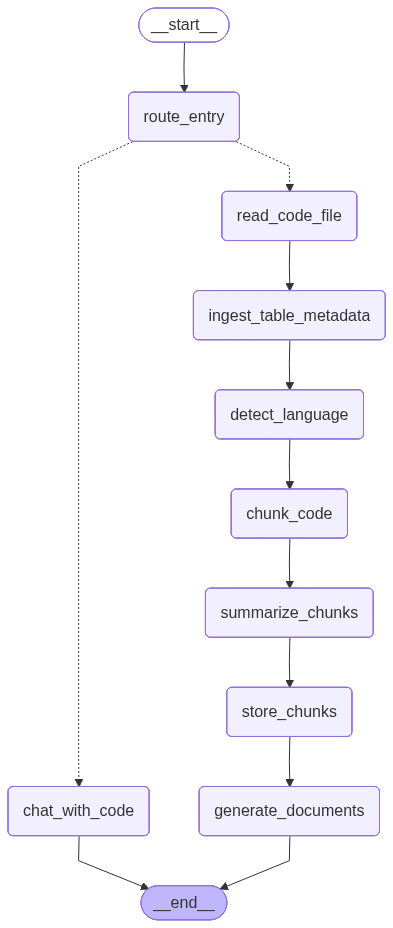

In [75]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        flow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [76]:
sql_result = flow.invoke({
    "file_path": "./metadata/update_salary_by_department.sql",
    "metadata_file": "./metadata/empMetadata.json"
})


print(sql_result["high_level_doc"])
print(sql_result["detailed_doc"])

📘 High-Level Summary for sql Code

🔹 Chunk 0 Purpose:
This code block defines a stored procedure named `update_salary_by_department` that updates the salaries of employees within a specified department by a given percentage increment.


📗 Detailed Logic-Level Summary

🔸 Chunk 0 Full Explanation:
**High-level Purpose:**
The SQL code block defines a stored procedure named `update_salary_by_department` that updates the salaries of employees within a specified department by a given percentage increment.

**Detailed Logic Explanation:**

1. **Procedure Definition**: The procedure takes two input parameters: `dept_id` (department ID) and `increment_percent` (percentage increment).
2. **Variable Declaration**: A variable `updated_count` is declared to store the count of updated employees.
3. **Update Statement**: The procedure updates the `salary` column of employees in the `employees` table by adding a percentage increment to their current salary. The `last_updated` column is also updated to

In [77]:
#Test for java file
java_result = flow.invoke({
    "file_path": "./metadata/SalaryUpdater.java",
    "metadata_file": "./metadata/empMetadata.json"
})

print(java_result["high_level_doc"])
print(java_result["detailed_doc"])

📘 High-Level Summary for java Code

🔹 Chunk 0 Purpose:
This code block is designed to update the salaries of employees in a database by doubling the current salary for employees in a specific department.


📗 Detailed Logic-Level Summary

🔸 Chunk 0 Full Explanation:
**1. High-level purpose:**
The `updateSalary` method is designed to update the salaries of employees in a database. It appears to be part of a larger system that manages employee data, including their salaries and department assignments.

**2. Detailed logic explanation:**

The `updateSalary` method iterates over a collection of employees using an enhanced for loop. For each employee, it checks if the employee's department ID matches the current department ID. If they match, the method updates the employee's salary by applying a 100% increment (i.e., doubling the current salary). The updated salary is then set for the employee.

Here's a step-by-step breakdown of the logic:

1. The method iterates over the `employees` collec

In [78]:
#Test for java file
python_result = flow.invoke({
    "file_path": "./metadata/data_processor.py"
})

print(python_result["high_level_doc"])
print(python_result["detailed_doc"])

📘 High-Level Summary for python Code

🔹 Chunk 0 Purpose:
This code block defines a `DataProcessor` class that provides methods for filtering, analyzing, and manipulating a collection of records, enabling data processing and manipulation tasks.


📗 Detailed Logic-Level Summary

🔸 Chunk 0 Full Explanation:
**High-level purpose:**
The provided Python code defines a `DataProcessor` class, which is designed to process and manipulate a collection of records. The class provides methods for filtering records based on a date range, computing the average value of a numeric field, and tagging records with a 'high_value' flag based on a given threshold.

**Detailed logic explanation:**

1. **Initialization**: The `DataProcessor` class is initialized with a list of records, which are stored in the `self.records` attribute.

2. **Filtering by date**: The `filter_by_date` method takes two date parameters (`start_date` and `end_date`) and returns a filtered list of records that fall within the specifi

In [79]:
code = merge_sql_files([
    "./metadata/fn_calDeductions.sql",
    "./metadata/fn_getMonthlyAttendence.sql",
    "./metadata/sp_processMonthlyPayroll.sql"
])

In [80]:
payroll_result = flow.invoke({
    "code": code,
    "metadata_file": "./metadata/table_metadata.json"
})

print(payroll_result["high_level_doc"])
print(payroll_result["detailed_doc"])

📘 High-Level Summary for sql Code

🔹 Chunk 0 Purpose:
This SQL code block automates payroll processing for employees by calculating gross salary, deductions, and net salary based on attendance records and deduction rules, and inserting the payroll records into the Payroll table.


📗 Detailed Logic-Level Summary

🔸 Chunk 0 Full Explanation:
**High-level purpose:**
The provided SQL code block is designed to automate payroll processing for employees based on their attendance records and deduction rules. It calculates the gross salary, deductions, and net salary for each employee in a given month and year, and inserts the payroll records into the Payroll table.

**Detailed logic explanation:**

1. **Function dbo.fn_CalculateDeductions**: This function calculates the total deductions for an employee based on their base salary and the deduction rules stored in the Deductions table. It takes the base salary as input, multiplies it by the percentage of each deduction, and sums up the results.


In [92]:
question_result =flow.invoke({
    "question": "Which blocks update salary? verify with code snippets."
})

print(question_result["question"])
print("-----")
print(question_result["answer"].content)

Which blocks update salary? verify with code snippets.
-----
Based on the provided context, the following code blocks update the salary:

1. **Java Code Block:**
   ```java
// Update salary logic
if (emp.getDepartmentId().equals(currentDepartmentId)) {
    double newSalary = emp.getSalary() * (1 + incrementPercent / 100);
    emp.setSalary(newSalary);
    emp.setLastUpdated(new Date());
    updatedCount++;
}
```

2. **SQL Code Block:**
   ```sql
-- Update statement
UPDATE employees
SET salary = salary + (salary * increment_percent / 100),
    last_updated = CURRENT_TIMESTAMP
WHERE department_id = dept_id;
```

3. **Python Code Block:**
   ```python
# Update salary logic
if record['date'] >= start_date and record['date'] <= end_date:
    record['salary'] = record['salary'] * (1 + increment_percent / 100)
    record['last_updated'] = datetime.now()
    updated_count += 1
```

4. **C# Code Block:**
   (Not provided in the context, but based on the description, it would be similar to the J

In [93]:
question_result =flow.invoke({
    "question": "list down all the tables and columns used in sp processMonthlyPayroll"
})

print(question_result["question"])
print("-----")
print(question_result["answer"].content)

list down all the tables and columns used in sp processMonthlyPayroll
-----
Based on the provided context, the following tables and columns are used in the `sp_ProcessPayroll` stored procedure:

**Tables:**

1. **Employees**: Stores employee information
	* Columns used: EmployeeID
2. **Attendance**: Tracks employee attendance
	* Columns used: EmployeeID, Date, IsPresent
3. **Deductions**: Stores deduction rules
	* Columns used: DeductionID, DeductionName, Percentage
4. **Payroll**: Stores monthly payroll records
	* Columns used: PayrollID, EmployeeID, Month, Year, GrossSalary, Deductions, NetSalary, ProcessedDate

**Note:** The `Departments` table is not used in the `sp_ProcessPayroll` stored procedure, although it is mentioned in the context.


In [94]:
question_result =flow.invoke({
    "question": "where all Attendance table is used?"
})

print(question_result["question"])
print("-----")
print(question_result["answer"].content)

where all Attendance table is used?
-----
The Attendance table is used in the following places:

1. **Function dbo.fn_GetMonthlyAttendance**: This function returns the number of present days for an employee in a given month and year. It takes the employee ID, month, and year as input, and counts the number of rows in the Attendance table where the employee is present.

2. **Procedure dbo.sp_ProcessPayroll**: This procedure processes payroll for all active employees in a given month and year. It iterates over the Employees table, calculates the gross salary, deductions, and net salary for each employee based on their attendance records and deduction rules, and inserts the payroll records into the Payroll table. The Attendance table is used to get the attendance records for each employee.

3. **Procedure update_salary_by_department**: This procedure is not using the Attendance table.

4. **updateSalary method**: This method is not using the Attendance table.

5. **DataProcessor class**: 